# **Part 1: Data Ingestion**

In [ ]:
!pip install polars duckdb plotly streamlit


In [ ]:
!mkdir data
!mkdir data/raw


mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/raw’: File exists


In [ ]:
import requests
import polars as pl

tripData = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet"
zoneLookup = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"

tripDataPath = "data/raw/yellow_tripdata_2024-01.parquet"
zoneLookupPath = "data/raw/taxi_zone_lookup.csv"

def download_file(url, dest):
  response = requests.get(url)
  response.raise_for_status()
  with open(dest, "wb") as f:
    f.write(response.content)
  print("file downloaded")

download_file(tripData,tripDataPath)
download_file(zoneLookup, zoneLookupPath)

file downloaded
file downloaded


In [ ]:
trips_df = pl.read_parquet(tripDataPath)
zones_df = pl.read_csv(zoneLookupPath)

print("Datasets loaded")

Datasets loaded


In [ ]:
expected_columns = {"tpep_pickup_datetime", "tpep_dropoff_datetime", "PULocationID", "DOLocationID", "passenger_count", "trip_distance", "fare_amount", "tip_amount", "total_amount", "payment_type"}

actual_columns = set(trips_df.columns)
missing_columns = expected_columns - actual_columns

if missing_columns:
  raise ValueError(f"Missing Expected COlumns: {missing_columns}")

print("All expected columns are present")

All expected columns are present


In [ ]:
try:
    trips_df = trips_df.with_columns([
        pl.col("tpep_pickup_datetime").cast(pl.Datetime),
        pl.col("tpep_dropoff_datetime").cast(pl.Datetime)
    ])
except Exception as e:
    raise TypeError("Datetime conversion failed") from e

print("Datetime columns validated successfully.")

Datetime columns validated successfully.


In [ ]:
row_count = trips_df.height
if row_count == 0:
    raise RuntimeError("Dataset contains zero rows after loading.")

print(f"Total rows: {row_count}")

Total rows: 2964624


# Part 2: Data Transformation & Analysis

In [ ]:
critical_columns = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "fare_amount",
    "trip_distance"
]

initialRowCount = trips_df.height

trips_df = trips_df.drop_nulls(subset=critical_columns)

newRowCount = trips_df.height
nullRows = initialRowCount - newRowCount
print(f"Removed {nullRows} rows due to null values.")

Removed 0 rows due to null values.


In [ ]:
rows_before_invalid = trips_df.height

trips_df = trips_df.filter(
    (pl.col("trip_distance") > 0) &
    (pl.col("fare_amount") >= 0) &
    (pl.col("fare_amount") <= 500)
)

rows_after_invalid = trips_df.height
invalidRows = rows_before_invalid - rows_after_invalid
print(f"Removed {invalidRows} rows due to invalid distance or fare.")


Removed 94466 rows due to invalid distance or fare.


In [ ]:
rows_before_time = trips_df.height

trips_df = trips_df.filter(
    pl.col("tpep_dropoff_datetime") >= pl.col("tpep_pickup_datetime")
)

rows_after_time = trips_df.height
timeRows = rows_before_time - rows_after_time
print(f"Removed {timeRows} rows due to invalid timestamps.")

Removed 56 rows due to invalid timestamps.


In [ ]:
finalRows = trips_df.height

print("\nDATA CLEANING SUMMARY")
print("-" * 30)
print(f"Initial rows: {initialRowCount}")
print(f"Removed {nullRows} rows due to null values.")
print(f"Removed {invalidRows} rows due to invalid distance or fare.")
print(f"Removed {timeRows} rows due to invalid timestamps.")
print(f"Final rows: {finalRows}")
print(f"Total rows removed: {initialRowCount - finalRows}")


DATA CLEANING SUMMARY
------------------------------
Initial rows: 2964624
Removed 0 rows due to null values.
Removed 94466 rows due to invalid distance or fare.
Removed 56 rows due to invalid timestamps.
Final rows: 2870102
Total rows removed: 94522


In [ ]:
trips_df = trips_df.with_columns(
    ((pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
     .dt.total_seconds() / 60)
    .alias("trip_duration_minutes")
)

print("trip_duration_minutes created.")

trip_duration_minutes created.


In [ ]:
trips_df = trips_df.with_columns([

    pl.when(pl.col("trip_duration_minutes") > 0)
      .then(pl.col("trip_distance") / (pl.col("trip_duration_minutes") / 60))
      .otherwise(0)
      .alias("trip_speed_mph"),

    pl.col("tpep_pickup_datetime").dt.hour().alias("pickup_hour"),

    pl.col("tpep_pickup_datetime").dt.strftime("%A").alias("pickup_day_of_week")
])

print("trip_speed_mph created.")
print("pickup_hour created.")
print("pickup_day_of_week created.")

trip_speed_mph created.
pickup_hour created.
pickup_day_of_week created.


In [ ]:
import duckdb

con = duckdb.connect()

con.register("trips", trips_df)
con.register("zones", zones_df)

print("DuckDB tables registered.")

DuckDB tables registered.


### Query 1: Top 10 busiest pickup zones by number of trips

In [ ]:
con.execute("""
SELECT
    z.Zone AS pickup_zone,
    COUNT(*) AS total_trips
FROM trips t
JOIN zones z
    ON t.PULocationID = z.LocationID
GROUP BY pickup_zone
ORDER BY total_trips DESC
LIMIT 10
""").df()

,pickup_zone,total_trips
0,Midtown Center,140161
1,Upper East Side South,140134
2,JFK Airport,138478
3,Upper East Side North,133975
4,Midtown East,104356
5,Times Sq/Theatre District,102972
6,Penn Station/Madison Sq West,102161
7,Lincoln Square East,101800
8,LaGuardia Airport,87715
9,Upper West Side South,86475


### Query 2: Average fare amount for each hour of the day

In [ ]:
con.execute("""
SELECT
    pickup_hour,
    AVG(fare_amount) AS avg_fare
FROM trips
GROUP BY pickup_hour
ORDER BY pickup_hour
""").df()

,pickup_hour,avg_fare
0,0,19.679250
1,1,17.732032
2,2,16.621723
3,3,18.530033
4,4,23.435229
5,5,27.492713
6,6,22.026585
7,7,18.749879
8,8,17.822939
9,9,17.943989


### Query 3: Percentage of trips by payment type

In [ ]:
con.execute("""
SELECT
    CASE payment_type
        WHEN 0 THEN '1 - Credit Card'
        WHEN 1 THEN '2 - Cash'
        WHEN 2 THEN '3 - No Charge'
        WHEN 3 THEN '4 - Dispute'
        WHEN 4 THEN '5 - Unknown'
        ELSE 'other'
    END AS payment_type,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER () AS percentage
FROM trips
GROUP BY payment_type
ORDER BY payment_type
""").df()

,payment_type,percentage
0,1 - Credit Card,4.015363
1,2 - Cash,80.081196
2,3 - No Charge,14.735400
3,4 - Dispute,0.370997
4,5 - Unknown,0.797045


### Query 4: Average tip percentage by day of week (credit card payments only)

In [ ]:
con.execute("""
SELECT
    pickup_day_of_week,
    AVG(tip_amount / fare_amount) * 100 AS avg_tip_percentage
FROM trips
WHERE payment_type = 0
  AND fare_amount > 0
GROUP BY pickup_day_of_week
ORDER BY avg_tip_percentage DESC
""").df()

,pickup_day_of_week,avg_tip_percentage
0,Wednesday,10.711981
1,Friday,10.627572
2,Thursday,10.468414
3,Tuesday,9.777172
4,Monday,8.578372
5,Saturday,7.553313
6,Sunday,6.823112


### Query 5: Top 5 most common pickup-dropoff zone pairs

In [ ]:
con.execute("""
SELECT
    pu.Zone AS pickup_zone,
    dz.Zone AS dropoff_zone,
    COUNT(*) AS trip_count
FROM trips t
JOIN zones pu ON t.PULocationID = pu.LocationID
JOIN zones dz ON t.DOLocationID = dz.LocationID
GROUP BY pickup_zone, dropoff_zone
ORDER BY trip_count DESC
LIMIT 5
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,pickup_zone,dropoff_zone,trip_count
0,Upper East Side South,Upper East Side North,21642
1,Upper East Side North,Upper East Side South,19199
2,Upper East Side North,Upper East Side North,15200
3,Upper East Side South,Upper East Side South,14119
4,Midtown Center,Upper East Side South,10139


# Part 3: Dashboard Development

In [ ]:
!mkdir data/processed

trips_df.write_parquet("data/processed/cleaned_trips.parquet")
print("Processed data saved.")

mkdir: cannot create directory ‘data/processed’: File exists
Processed data saved.


In [ ]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pdf = trips_df.to_pandas()

Bar Chart

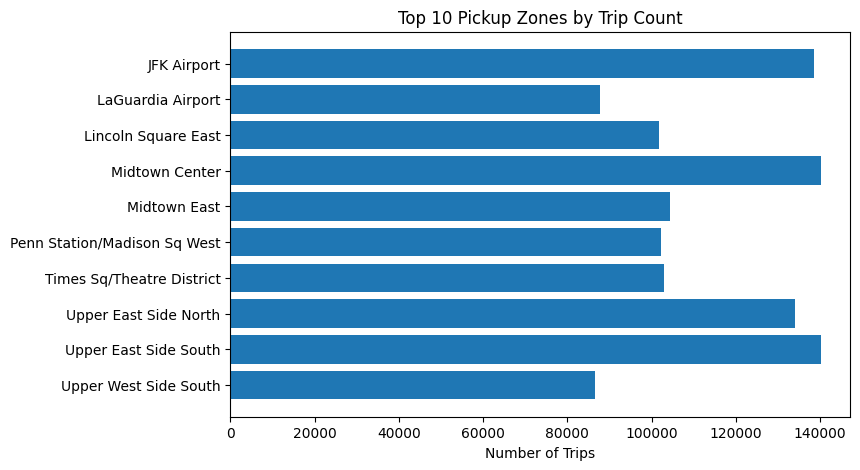

In [ ]:
top_pickups = (
    trips_df
    .group_by("PULocationID")
    .len()
    .sort("len", descending=True)
    .head(10)
    .join(zones_df, left_on="PULocationID", right_on="LocationID")
)

plt.figure(figsize=(8, 5))
plt.barh(top_pickups["Zone"].to_list(), top_pickups["len"].to_list())
plt.xlabel("Number of Trips")
plt.title("Top 10 Pickup Zones by Trip Count")
plt.gca().invert_yaxis()
plt.show()

Line Chart

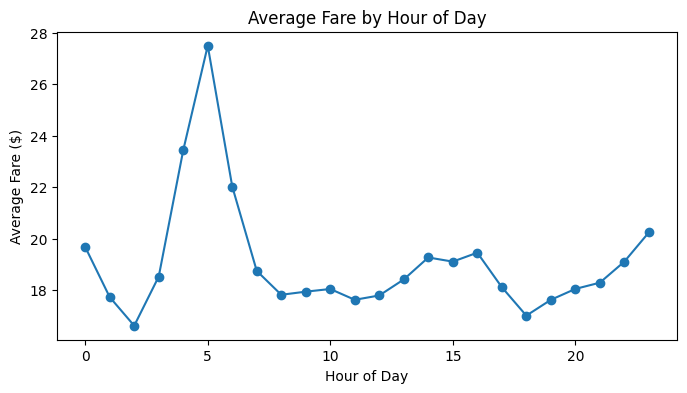

In [ ]:
avg_fare_by_hour = (
    trips_df
    .group_by("pickup_hour")
    .agg(pl.col("fare_amount").mean())
    .sort("pickup_hour")
)

plt.figure(figsize=(8, 4))
plt.plot(
    avg_fare_by_hour["pickup_hour"].to_list(),
    avg_fare_by_hour["fare_amount"].to_list(),
    marker="o"
)
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare ($)")
plt.title("Average Fare by Hour of Day")
plt.show()

Histogram

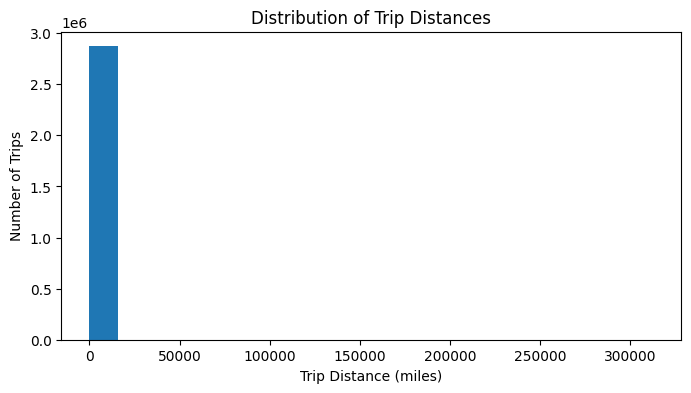

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(
    trips_df["trip_distance"].to_list(),
    bins=20
)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Distances")
plt.show()

Bar Chart

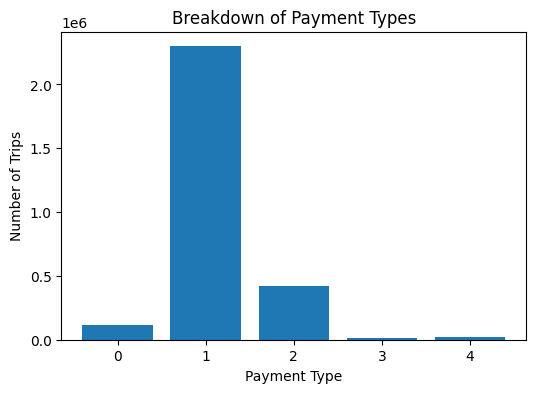

In [ ]:
payment_counts = (
    trips_df
    .group_by("payment_type")
    .len()
    .sort("payment_type")
)

plt.figure(figsize=(6, 4))
plt.bar(
    payment_counts["payment_type"].to_list(),
    payment_counts["len"].to_list()
)
plt.xlabel("Payment Type")
plt.ylabel("Number of Trips")
plt.title("Breakdown of Payment Types")
plt.show()

Heatmap

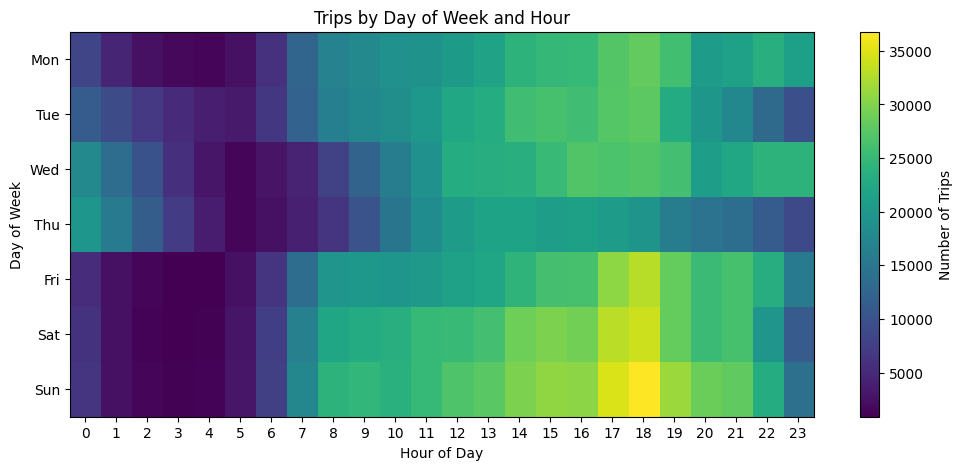

In [ ]:
import numpy as np

heatmap_df = (
    trips_df
    .group_by(["pickup_day_of_week", "pickup_hour"])
    .agg(pl.len().alias("trip_count"))
    .sort(["pickup_day_of_week", "pickup_hour"])
)

heatmap_pivot = heatmap_df.pivot(
    values="trip_count",
    index="pickup_day_of_week",
    on="pickup_hour"
).fill_null(0)

heatmap_matrix = heatmap_pivot.drop("pickup_day_of_week").to_numpy().astype(float)

plt.figure(figsize=(12, 5))
plt.imshow(heatmap_matrix, aspect="auto", cmap="viridis")
plt.colorbar(label="Number of Trips")

plt.xticks(ticks=np.arange(0, 24), labels=np.arange(0, 24))
plt.xlabel("Hour of Day")

weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.yticks(ticks=np.arange(0, 7), labels=weekdays)
plt.ylabel("Day of Week")

plt.title("Trips by Day of Week and Hour")
plt.show()

## AI Tools Used

ChatGPT was used to assist with:
- Designing the data pipeline structure
- Writing and debugging Python, Polars, DuckDB, and Streamlit code
- Explaining errors and improving code clarity

All code was reviewed, understood, and adapted by the author.